In [2]:
import numpy as np
import pandas as pd
import cvxpy as cp

import matplotlib
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy
import helper.entsoe_wrapper as entsoe
import helper.intensity as intensity
import helper.capacity as capacity
import helper.util as utility
import gurobipy as gp
import usecase.solve as solve

In [3]:
start=pd.Timestamp('2022-01-01',tz='utc')
end=pd.Timestamp('2023-01-01',tz='utc')
timesteps = 8760

## 1. Loading Data

In [ ]:
country_list   = ["DE","IE", "PL", "ES", "AT", "BE", "NL", "FR", "IT", "SE"]
price_all_loc  = []
carbon_all_loc = []
carbon_flow_all_loc = []
water_all_loc  = []
water_flow_all_loc = []
water_weighted_all_loc=[]
water_weighted_flow_all_loc=[]
capacity_all_loc = []

timesteps = 8760

for country in country_list:
    print(country)
    df             = entsoe.get_price_data(country, start, end)
    price_array    = df.iloc[:timesteps,0]
    price_all_loc += [price_array]
    
    df              = intensity.get_average_intensity(country, start, end, water=False)
    carbon_array    = df.to_numpy()[:timesteps]
    carbon_all_loc += [carbon_array]

    df             = intensity.get_average_intensity_flow(country, start, end)
    carbon_array    = df.to_numpy()[:timesteps]
    carbon_flow_all_loc += [carbon_array]
    
    df             = intensity.get_complete_WUE(country, start, end,flow=False,weighted=False)
    water_array    = df.to_numpy()[:timesteps]
    water_all_loc += [water_array] 

    df             = intensity.get_complete_WUE(country, start, end,flow=False,weighted=True)
    water_array    = df.to_numpy()[:timesteps]
    water_weighted_all_loc += [water_array] 
    
    df             = intensity.get_complete_WUE(country, start, end, flow=True, weighted=False)
    water_array    = df.to_numpy()[:timesteps]
    water_flow_all_loc += [water_array]   

    df             = intensity.get_complete_WUE(country, start, end,flow=True,weighted=True)
    water_array    = df.to_numpy()[:timesteps]
    water_weighted_flow_all_loc += [water_array] 

    df          = capacity.get_usage_percentage_variable_generation(country, start, end)
    capacity_array = df.to_numpy()[:timesteps]
    capacity_all_loc += [capacity_array]





price_all_loc  = np.stack(price_all_loc,  axis=0)
carbon_all_loc = np.stack(carbon_all_loc, axis=0)
carbon_flow_all_loc = np.stack(carbon_flow_all_loc, axis=0)
water_all_loc  = np.stack(water_all_loc,  axis=0)
water_weighted_all_loc  = np.stack(water_weighted_all_loc,  axis=0)
water_flow_all_loc  = np.stack(water_flow_all_loc,  axis=0)
water_weighted_flow_all_loc  = np.stack(water_weighted_flow_all_loc,  axis=0)
capacity_all_loc = np.stack(capacity_all_loc,  axis=0)
capacity_all_loc=capacity_all_loc.reshape(-1,timesteps)

price_all_loc_unscaled=deepcopy(price_all_loc)
carbon_all_loc_unscaled=deepcopy(carbon_all_loc)
carbon_flow_all_loc_unscaled=deepcopy(carbon_flow_all_loc)
water_all_loc_unscaled=deepcopy(water_all_loc)
water_flow_all_loc_unscaled=deepcopy(water_flow_all_loc)

# Normalize
price_all_loc   = (price_all_loc-price_all_loc.min())/(price_all_loc.max()-price_all_loc.min())
carbon_all_loc    = (carbon_all_loc-carbon_all_loc.min())/(carbon_all_loc.max()-carbon_all_loc.min())
carbon_flow_all_loc    = (carbon_flow_all_loc-carbon_flow_all_loc.min())/(carbon_flow_all_loc.max()-carbon_flow_all_loc.min())
water_all_loc    = (water_all_loc-water_all_loc.min())/(water_all_loc.max()-water_all_loc.min())
water_weighted_all_loc    = (water_weighted_all_loc-water_weighted_all_loc.min())/(water_weighted_all_loc.max()-water_weighted_all_loc.min())
water_flow_all_loc    = (water_flow_all_loc-water_flow_all_loc.min())/(water_flow_all_loc.max()-water_flow_all_loc.min())
water_weighted_flow_all_loc    = (water_weighted_flow_all_loc-water_weighted_flow_all_loc.min())/(water_weighted_flow_all_loc.max()-water_weighted_flow_all_loc.min())
capacity_all_loc = (capacity_all_loc-capacity_all_loc.min())/(capacity_all_loc.max()-capacity_all_loc.min())

DE
IE
PL
ES


In [4]:
wkld_csv_file  = "usecase/AI_workload.csv"
df             = pd.read_csv(wkld_csv_file,index_col=0,parse_dates=True)
df_extend = utility.extend_workload(df, timesteps)
workload_trace = df_extend["Power (Watt)"].to_numpy()
workload_trace = (workload_trace-workload_trace.min())/(workload_trace.max()-workload_trace.min())*6.7
#workload_trace = np.repeat(workload_trace.reshape([1,-1])/10, 10, axis=0)

### 1.1 Preprocess Data

In [5]:
si        = 0
ei        = timesteps
num_ins   = ei - si

price_all_loc  = price_all_loc[:, si:ei]
carbon_all_loc = carbon_all_loc[:, si:ei]
water_all_loc  = water_all_loc[:, si:ei]
water_flow_all_loc = water_flow_all_loc[:, si:ei]
water_weighted_all_loc = water_weighted_all_loc[:, si:ei]
water_weighted_flow_all_loc = water_weighted_flow_all_loc[:, si:ei]
capacity_all_loc = capacity_all_loc[:, si:ei]
workload_trace = workload_trace[si:ei]

## 2 Optimiation

### 2.1 Cost Optimization 

In [6]:
optimal_cost_1,energy_usage_1=solve.offline_solver_gurobi(price_all_loc,  water_flow_all_loc,carbon_flow_all_loc, workload_trace,timesteps,l_0=1,l_1=0,l_2=0,max_cap=0.67)

### 2.2 Water Optimization

In [7]:
optimal_cost_2,energy_usage_2=solve.offline_solver_gurobi(price_all_loc,  water_all_loc,carbon_all_loc, workload_trace,timesteps,l_0=0,l_1=1,l_2=0,max_cap=0.67)

### 2.3 Carbon Optimization

In [8]:
optimal_cost_3,energy_usage_3=solve.offline_solver_gurobi(price_all_loc,  water_all_loc,carbon_all_loc, workload_trace,timesteps,l_0=0,l_1=0,l_2=1,max_cap=0.67)

### 2.4 Capacity Optimization

In [9]:
optimal_cost_4,energy_usage_4=solve.offline_solver_gurobi_capa(price_all_loc,water_all_loc,carbon_all_loc,capacity_all_loc,workload_trace,timesteps,l_0=0,l_1=0,l_2=0,l_3=1,max_cap=0.67)

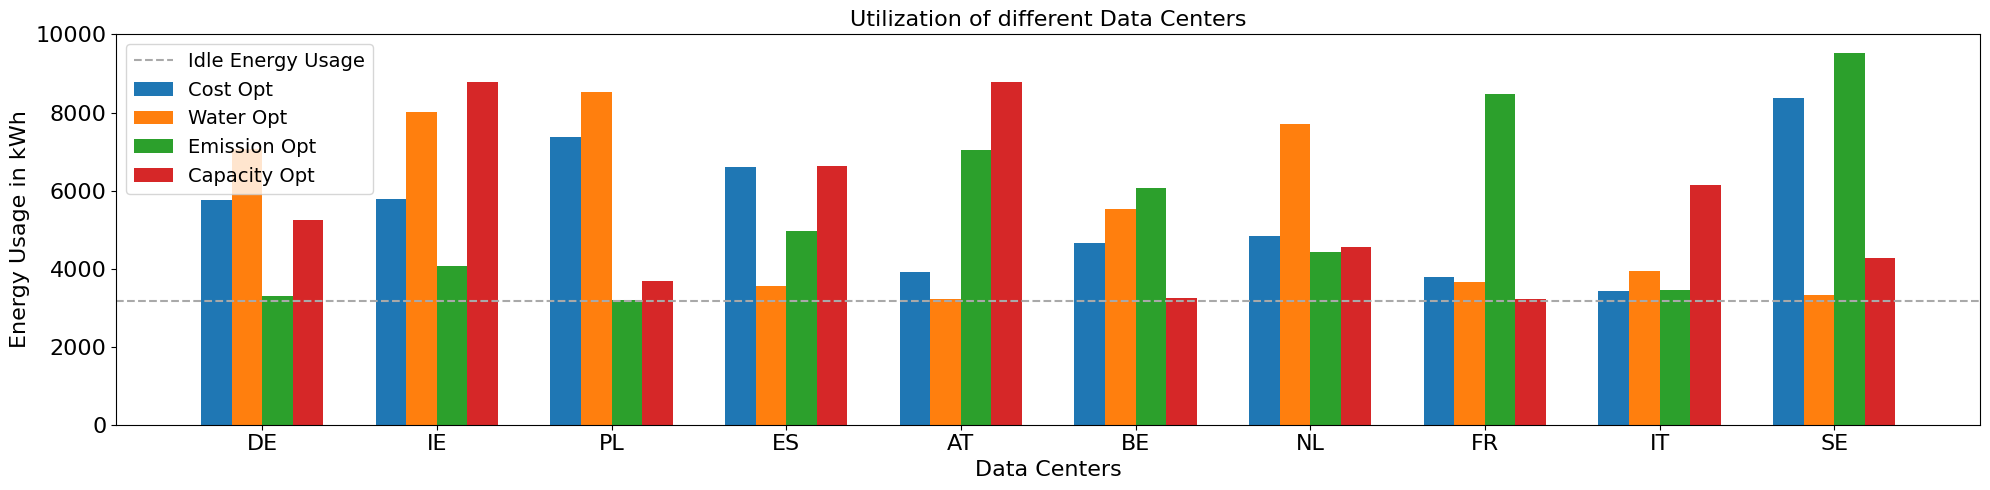

In [10]:
# Print a bar diagram for each entry in energy_usage and energy_usage_flow that compares the energy usage of the two solutions
labels = country_list
energy_usage_sum_1 = [np.sum(energy_usage_1[i]) for i in range(10)]
energy_usage_sum_2 = [np.sum(energy_usage_2[i]) for i in range(10)]
energy_usage_sum_3 = [np.sum(energy_usage_3[i]) for i in range(10)]
energy_usage_sum_4 = [np.sum(energy_usage_4[i]) for i in range(10)]
 

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(7, 2))
rects1 = ax.bar(x - 3*width/4, energy_usage_sum_1, width/2, label='Cost Opt')
rects2 = ax.bar(x - width/4, energy_usage_sum_2, width/2, label='Water Opt')
rects3 = ax.bar(x + width/4, energy_usage_sum_3, width/2, label='Emission Opt')
rects4 = ax.bar(x + 3*width/4, energy_usage_sum_4,width/2,label="Capacity Opt")
#Plot a line at idle energy usage at 0.33*1.1*8760
ax.axhline(y=0.33*1.1*8760, color='darkgrey', linestyle='--',label='Idle Energy Usage')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Data Centers',size=16)
ax.set_ylabel('Energy Usage in kWh',size=16)
ax.set_title('Utilization of different Data Centers',size=16)
ax.set_xticks(x)
ax.set_xticklabels(labels,size=16)
ax.legend(fontsize=14)
#set font size of y labels
ax.tick_params(axis='y', labelsize=16)
fig.tight_layout()
plt.savefig("energy_usage_comparison.png")
plt.show()


### 2.5 Water Flow 

In [11]:
optimal_cost_5,energy_usage_5=solve.offline_solver_gurobi(price_all_loc, water_flow_all_loc, carbon_all_loc,workload_trace,timesteps,l_0=0,l_1=1,l_2=0,max_cap=0.67)

### 2.6 Weighted Water

In [12]:
optimal_cost_6,energy_usage_6=solve.offline_solver_gurobi(price_all_loc, water_weighted_all_loc, carbon_all_loc,workload_trace,timesteps,l_0=0,l_1=1,l_2=0,max_cap=0.67)

Monthly consumption in BE

C:\Users\jos82vs.UNI-WUERZBURG\AppData\Local\Temp\ipykernel_5084\582568031.py:6: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  con_be_monthly = con_be.resample('m').sum()
C:\Users\jos82vs.UNI-WUERZBURG\AppData\Local\Temp\ipykernel_5084\582568031.py:7: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  con_be_weighted_monthly = con_be_weighted.resample('m').sum()


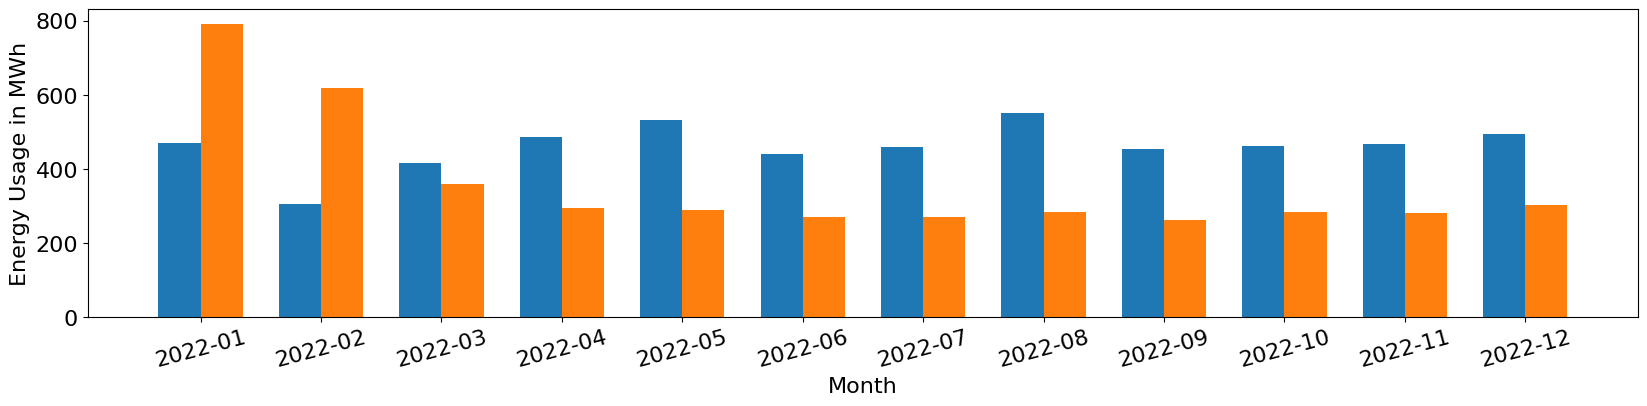

In [13]:
index = country_list.index("BE")
con_be_weighted = pd.DataFrame(energy_usage_6[index], index=pd.date_range(start=start, end=end-pd.Timedelta(hours=1), freq='h'))
con_be = pd.DataFrame(energy_usage_2[index], index=pd.date_range(start=start, end=end-pd.Timedelta(hours=1), freq='h'))

# Resample the data to monthly sums
con_be_monthly = con_be.resample('m').sum()
con_be_weighted_monthly = con_be_weighted.resample('m').sum()

# Create a bar plot
fig, ax = plt.subplots(figsize=(20, 4))
width = 0.35  # the width of the bars

# Plot the bars
con_be_monthly.index = con_be_monthly.index.strftime('%Y-%m')
con_be_weighted_monthly.index = con_be_weighted_monthly.index.strftime('%Y-%m')
x = np.arange(len(con_be_monthly.index))  # the label locations

rects1 = ax.bar(x - width/2, con_be_monthly.values.flatten(), width, label='Without Weighting')
rects2 = ax.bar(x + width/2, con_be_weighted_monthly.values.flatten(), width, label='With Weighting')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Month',size=16)
ax.set_ylabel('Energy Usage in MWh',size=16)
ax.set_xticks(x)
ax.set_xticklabels(con_be_monthly.index, rotation=15,size=16)
ax.tick_params(axis='y', labelsize=16)
plt.savefig("monthly_energy_usage_BE.png",bbox_inches='tight')
plt.show()

### 2.7 Water Combined

In [14]:
optimal_cost_7,energy_usage_7=solve.offline_solver_gurobi(price_all_loc, water_weighted_flow_all_loc, carbon_all_loc,workload_trace,timesteps,l_0=0,l_1=1,l_2=0,max_cap=0.67)

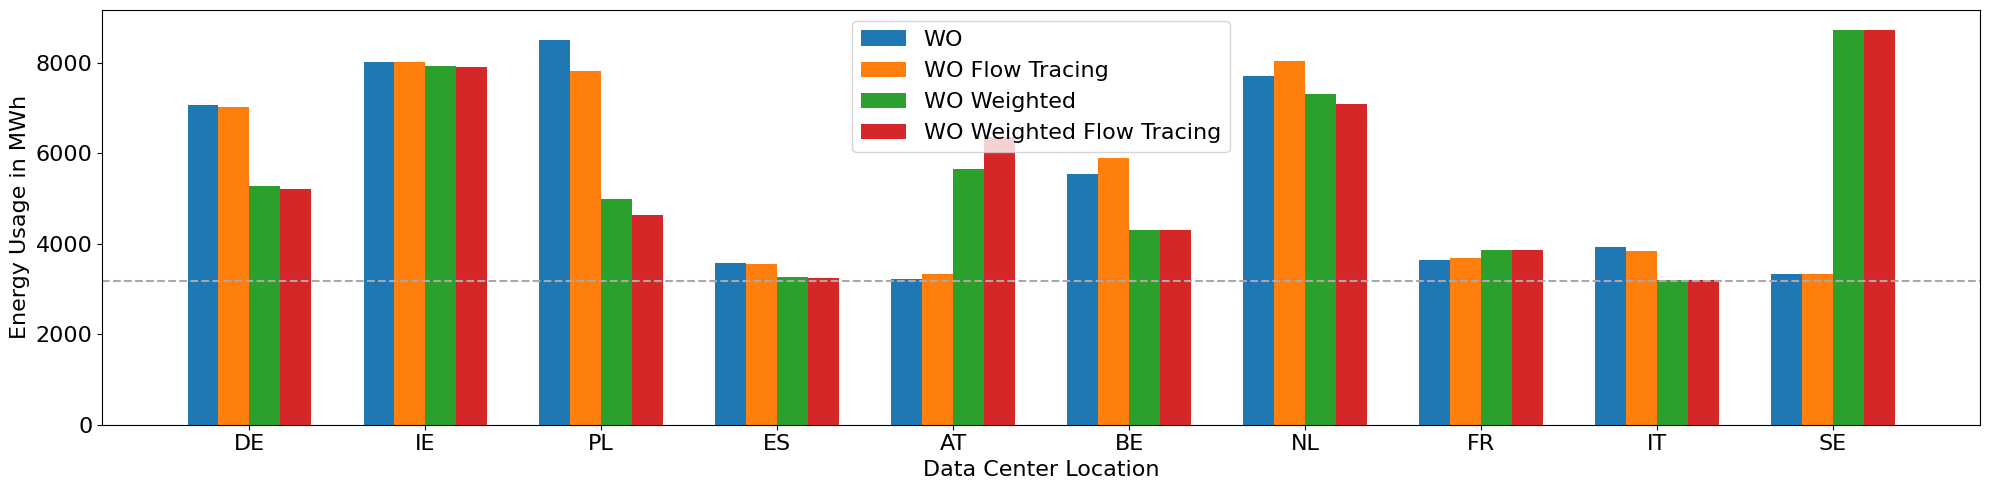

In [15]:
# Print a bar diagram for each entry in energy_usage and energy_usage_flow that compares the energy usage of the two solutions
labels = country_list
energy_usage_sum_1 = [np.sum(energy_usage_2[i]) for i in range(10)]
energy_usage_sum_2 = [np.sum(energy_usage_5[i]) for i in range(10)]
energy_usage_sum_3 = [np.sum(energy_usage_6[i]) for i in range(10)]
energy_usage_sum_4 = [np.sum(energy_usage_7[i]) for i in range(10)]
 

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 5))
rects1 = ax.bar(x  - 3*width/4, energy_usage_sum_1, width/2, label='WO')
rects2 = ax.bar(x - width/4, energy_usage_sum_2, width/2, label='WO Flow Tracing')
rects3 = ax.bar(x + width/4, energy_usage_sum_3, width/2, label='WO Weighted')
rects4 = ax.bar(x + 3*width/4, energy_usage_sum_4, width/2, label='WO Weighted Flow Tracing')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Data Center Location',size=16)
ax.set_ylabel('Energy Usage in MWh',size=16)
ax.set_xticks(x)
ax.set_xticklabels(labels,size=16)
ax.legend(fontsize=16)
ax.tick_params(axis='y', labelsize=16)
#Plot a line at idle energy usage at 0.33*1.1*8760
ax.axhline(y=0.33*1.1*8760, color='darkgrey', linestyle='--',label='Idle Energy Usage')
fig.tight_layout()
plt.savefig("energy_usage_comparisonWO.png")
plt.show()

In [16]:
energy_list=[energy_usage_1,energy_usage_2,energy_usage_3,energy_usage_4,energy_usage_5,energy_usage_6,energy_usage_7]
for energy in energy_list:
    print(np.sum(energy*carbon_all_loc_unscaled))

7957082.465501602
9423727.195092708
5761145.167447738
7901566.395932811
9272670.921046216
7682502.367606348
7574733.810407196


### 2.8 MinMax Optimization

In [17]:
optimal_cost_8,energy_usage_8=solve.offline_solver_gurobi(price_all_loc, water_all_loc, carbon_all_loc,workload_trace,timesteps,l_0=0,l_1=1,l_2=0,max_cap=0.67,f_type="MAX")

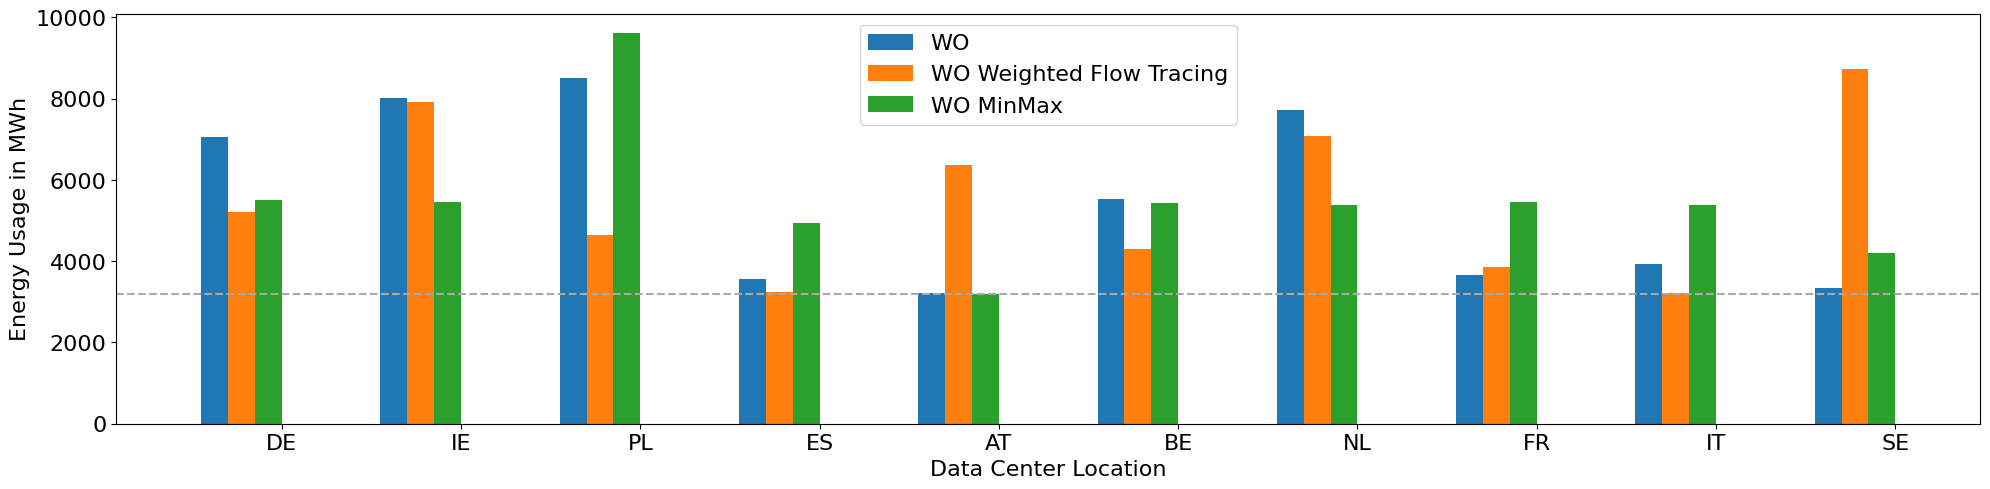

In [18]:
# Print a bar diagram for each entry in energy_usage and energy_usage_flow that compares the energy usage of the two solutions
labels = country_list
energy_usage_sum_1 = [np.sum(energy_usage_2[i]) for i in range(10)]
energy_usage_sum_2 = [np.sum(energy_usage_7[i]) for i in range(10)]
energy_usage_sum_3 = [np.sum(energy_usage_8[i]) for i in range(10)]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 5))
rects1 = ax.bar(x  - 5*width/4, energy_usage_sum_1, width/2, label='WO')
rects1 = ax.bar(x  - 3*width/4, energy_usage_sum_2, width/2, label='WO Weighted Flow Tracing')
rects2 = ax.bar(x - width/4, energy_usage_sum_3, width/2, label='WO MinMax')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Data Center Location',size=16)
ax.set_ylabel('Energy Usage in MWh',size=16)
ax.set_xticks(x)
ax.set_xticklabels(labels,size=16)
ax.legend(fontsize=16)
ax.tick_params(axis='y', labelsize=16)
#Plot a line at idle energy usage at 0.33*1.1*8760
ax.axhline(y=0.33*1.1*8760, color='darkgrey', linestyle='--',label='Idle Energy Usage')
fig.tight_layout()
plt.savefig("minmax_EnergyComp.png")
plt.show()

### 2.9 Weighted MinMax

In [19]:
optimal_cost_9,energy_usage_9=solve.offline_solver_gurobi(price_all_loc, water_weighted_flow_all_loc, carbon_all_loc,workload_trace,timesteps,l_0=0,l_1=1,l_2=0,max_cap=0.67,f_type="MAX")

In [1]:
# Print a bar diagram for each entry in energy_usage and energy_usage_flow that compares the energy usage of the two solutions
labels = country_list
water_con=[np.sum(water_all_loc_unscaled[i]*energy_usage_2[i]) for i in range(10)]
water_con_weighted=[np.sum(water_all_loc_unscaled[i]*energy_usage_7[i]) for i in range(10)]
water_con_min=[np.sum(water_all_loc_unscaled[i]*energy_usage_8[i]) for i in range(10)]
water_con_weighted_min=[np.sum(water_all_loc_unscaled[i]*energy_usage_9[i]) for i in range(10)]

x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(7, 2))
rects1 = ax.bar(x - 3*width/4, water_con, width/2, label='WO Water Consumption')
rects2 = ax.bar(x - width/4, water_con_min, width/2, label='WO MinMaxWater')
rects3 = ax.bar(x + width/4, water_con_weighted, width/2, label='WO Weighting')
rects4 = ax.bar(x + 3*width/4, water_con_weighted_min, width/2, label='WO MinMax with Weighting')



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Data Center Location',size=16)
ax.set_ylabel('Water Consumption in m^3',size=16)
ax.set_ylabel('Water Consumption in m$^3$', size=16)
ax.set_xticks(x)
ax.set_xticklabels(labels,size=16)
ax.legend(fontsize=16)
ax.tick_params(axis='y', labelsize=16)
#Plot a line at idle energy usage at 0.33*1.1*8760
fig.tight_layout()
plt.savefig("water_con_minmax.png")
plt.show()

NameError: name 'country_list' is not defined

### 2.9 Single Optimal Location

In [21]:
# Calculate the cost, carbon, water and water_weighted optimal location

price_list= []
carbon_list= []
water_list= []
water_weighted_list= []

for country in country_list:
    price_list.append(sum(price_all_loc_unscaled[country_list.index(country)]*workload_trace))
    carbon_list.append(sum(carbon_all_loc_unscaled[country_list.index(country)]*workload_trace))
    water_list.append(sum(water_all_loc_unscaled[country_list.index(country)]*workload_trace))
    water_weighted_list.append(sum(water_weighted_all_loc[country_list.index(country)]*workload_trace))

In [22]:
# get index of minimum value in list
price_index = np.argmin(np.array(price_list))
carbon_index = np.argmin(np.array(carbon_list))
water_index = np.argmin(np.array(water_list))
water_weighted_index = np.argmin(np.array(water_weighted_list))
print("Price optimal location: ", country_list[price_index])
print("Carbon optimal location: ", country_list[carbon_index])
print("Water optimal location: ", country_list[water_index])
print("Water weighted optimal location: ", country_list[water_weighted_index])

Price optimal location:  SE
Carbon optimal location:  SE
Water optimal location:  PL
Water weighted optimal location:  SE


### Pareto Front of Cost, Water, Carbon and 

In [23]:
from tqdm import tqdm
# Pareto Optimal Front for all for objectives
optimal_cost_front = {}
energy_usage_front = {}

# Precompute the weights to avoid recalculating them in the loop
weights = [(l_0 / 10, l_1 / 10, (10-l_0-l_1) / 10) for l_0 in range(11) for l_1 in range(11 - l_0)]

for l_0, l_1, l_2 in tqdm(weights):
    optimal_cost_front[l_0, l_1, l_2], energy_usage_front[l_0, l_1, l_2] = solve.offline_solver_gurobi(
        price_all_loc, water_weighted_flow_all_loc, carbon_all_loc, workload_trace, timesteps,
        l_0=l_0, l_1=l_1, l_2=l_2, max_cap=0.67
    )

100%|██████████| 66/66 [03:02<00:00,  2.77s/it]


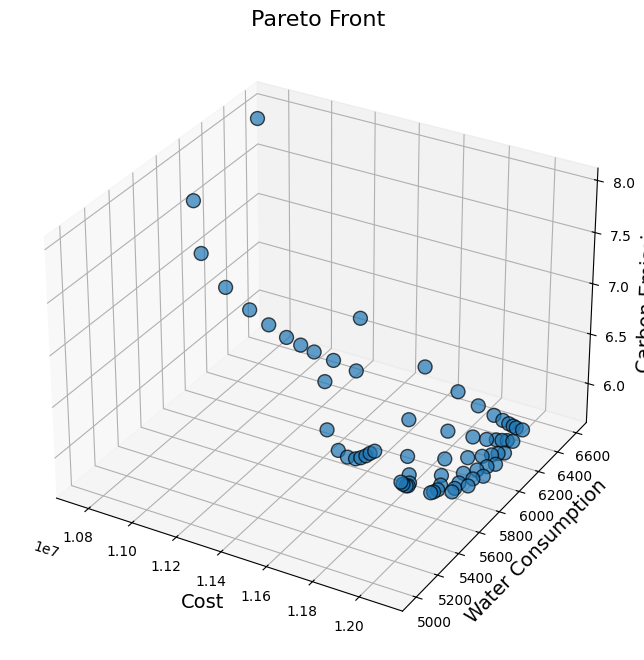

In [29]:
from mpl_toolkits.mplot3d import Axes3D

# Get the cost for each objective

costs = np.array([np.sum(energy_usage_front[l_0, l_1, l_2] * price_all_loc_unscaled) for l_0, l_1, l_2 in weights])
water_consumption = np.array([np.sum(energy_usage_front[l_0, l_1, l_2] * water_weighted_flow_all_loc) for l_0, l_1, l_2 in weights])
carbon_emission = np.array([np.sum(energy_usage_front[l_0, l_1, l_2] * carbon_all_loc_unscaled) for l_0, l_1, l_2 in weights])

# Plot the Pareto Front in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(costs, water_consumption, carbon_emission, s=100, edgecolors='k', alpha=0.7)
ax.set_xlabel('Cost', fontsize=14)
ax.set_ylabel('Water Consumption', fontsize=14)
ax.set_zlabel('Carbon Emission', fontsize=14)
ax.set_title('Pareto Front', fontsize=16)
plt.show()